In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# Load and preprocess dataset
file_path = 'BBVA.MC.csv'
df_BBVA = pd.read_csv(file_path)
df_BBVA = df_BBVA.interpolate(method='linear', limit_direction='both', axis=0)
df_BBVA['Date'] = pd.to_datetime(df_BBVA['Date'])
df_BBVA.set_index('Date', inplace=True)


In [2]:
# Set seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)


In [3]:
# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
df_close_BBVA = df_BBVA['Close'].values.reshape(-1, 1)
scaled_df_close_BBVA = scaler.fit_transform(df_close_BBVA)


In [4]:
# Split the data into training and testing datasets
train_size_BBVA = int(len(scaled_df_close_BBVA) * 0.8)
train_BBVA, test_BBVA = scaled_df_close_BBVA[:train_size_BBVA], scaled_df_close_BBVA[train_size_BBVA:]

In [5]:
# Create training and testing datasets
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 1
trainX_BBVA, trainY_BBVA = create_dataset(train_BBVA, look_back)
testX_BBVA, testY_BBVA = create_dataset(test_BBVA, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX_BBVA, (trainX_BBVA.shape[0], 1, trainX_BBVA.shape[1]))
testX = np.reshape(testX_BBVA, (testX_BBVA.shape[0], 1, testX_BBVA.shape[1]))

In [6]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error

# Function to create Keras model
def create_model(units):
    model = Sequential()
    model.add(LSTM(units, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Hyperparameters to search
units_options = np.arange(4, 44, 10)
epochs_options = [100, 150]

best_score = float('inf')
best_params = {}

for units in units_options:
    for epochs in epochs_options:
        tf.keras.backend.clear_session()
        model = create_model(units)
        model.fit(trainX, trainY_BBVA, epochs=epochs, batch_size=1, verbose=0)

        predictions = model.predict(testX).flatten()
        mse = mean_squared_error(testY_BBVA, predictions)

        if mse < best_score:
            best_score = mse
            best_params = {'units': units, 'epochs': epochs}

print("Best Model: MSE = %f using %s" % (best_score, best_params))

16/16 [==============================] - 0s 2ms/step
Best Model: MSE = 0.000218 using {'units': 14, 'epochs': 150}


In [7]:
# Recreate the best model using the identified parameters
model_best = create_model(best_params['units'])
model_best.fit(trainX, trainY_BBVA, epochs=best_params['epochs'], batch_size=1, verbose=1)


Epoch 1/150
2046/2046 [==============================] - 7s 2ms/step - loss: 0.0161
Epoch 2/150
2046/2046 [==============================] - 5s 2ms/step - loss: 3.5411e-04
Epoch 3/150
2046/2046 [==============================] - 5s 2ms/step - loss: 3.0604e-04
Epoch 4/150
2046/2046 [==============================] - 5s 2ms/step - loss: 2.8303e-04
Epoch 5/150
2046/2046 [==============================] - 5s 2ms/step - loss: 2.7214e-04
Epoch 6/150
2046/2046 [==============================] - 5s 2ms/step - loss: 2.6899e-04
Epoch 7/150
2046/2046 [==============================] - 4s 2ms/step - loss: 2.7189e-04
Epoch 8/150
2046/2046 [==============================] - 5s 2ms/step - loss: 2.6990e-04
Epoch 9/150
2046/2046 [==============================] - 5s 2ms/step - loss: 2.6961e-04
Epoch 10/150
2046/2046 [==============================] - 5s 2ms/step - loss: 2.6330e-04
Epoch 11/150
2046/2046 [==============================] - 5s 2ms/step - loss: 2.7345e-04
Epoch 12/150
2046/2046 [==========

In [8]:
# Make predictions on the test dataset
testPredictions = model_best.predict(testX).flatten()

# Invert predictions to original scale
testPredictions_original = scaler.inverse_transform(testPredictions.reshape(-1, 1)).flatten()
testY_original = scaler.inverse_transform(testY_BBVA.reshape(-1, 1)).flatten()


16/16 [==============================] - 0s 2ms/step


In [9]:


# Calculate performance metrics on the original scale
mse_original = mean_squared_error(testY_original, testPredictions_original)
rmse_original = np.sqrt(mse_original)
mape_original = np.mean(np.abs((testY_original - testPredictions_original) / testY_original)) * 100

print(f'Mean Squared Error (MSE) on Original Scale: {mse_original}')
print(f'Root Mean Squared Error (RMSE) on Original Scale: {rmse_original}')
print(f'Mean Absolute Percentage Error (MAPE) on Original Scale: {mape_original}%')


Mean Squared Error (MSE) on Original Scale: 0.013156795371648048
Root Mean Squared Error (RMSE) on Original Scale: 0.11470307481339831
Mean Absolute Percentage Error (MAPE) on Original Scale: 1.4196230639732632%


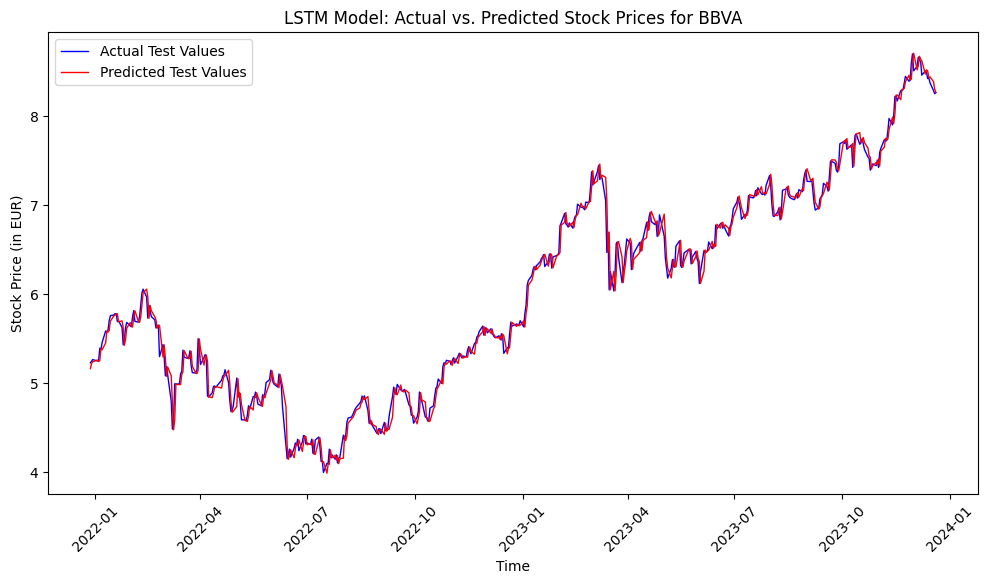

In [10]:
import matplotlib.pyplot as plt

# Plotting the final model predictions
plt.figure(figsize=(12,6))
plt.plot(df_BBVA.index[train_size_BBVA + look_back + 1:len(df_BBVA)], testY_original, label='Actual Test Values', color='blue', linewidth=1)
plt.plot(df_BBVA.index[train_size_BBVA + look_back + 1:len(df_BBVA)], testPredictions_original, label='Predicted Test Values', color='red', linewidth=1)
plt.title('LSTM Model: Actual vs. Predicted Stock Prices for BBVA')
plt.xlabel('Time')
plt.ylabel('Stock Price (in EUR)')
plt.legend()
plt.xticks(rotation=45)
plt.show()
